# DARPA Sunspot Prediction Challenge

*Author: Koki Sasagawa*  
*Date: 4/22/2019*

Use the sunspot data provided by DARPA and make predictions of future sunspots. 

Data: Yearly mean total sunspot number obtained by taking a simple arithmetic mean of the daily sunspot number over all days of each year (1700 - 2018).

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Custom 
from arima import ARIMA_model, time_series_split, evaluation

%matplotlib inline

In [2]:
# Set figure aesthetics
sns.set_style("darkgrid")

The sunspots data is a type of time series data. One of the main ideas behind making time series predictions is that past data is similar to the future. 

The future variable is essentially in some way **dependent** on the past. 

First, lets plot the data to see if it is a **deterministic** time series behaving in an expected manner or a **non-deterministic** time series which is stochastic or random in nature.

In [3]:
raw_data = './data/raw/'

files = os.listdir(raw_data)
for idx, fname in enumerate(files):
    print(idx, fname)

0 readme (1).txt
1 ISSN_Y_tot.csv
2 sunspots_yr_mean_train.csv
3 sunspots_yr_mean_test.csv
4 sunspots_yearly_multivariate-test.csv
5 sunspots_yearly_multivariate-train.csv
6 readme (2).txt


In [4]:
uni_var_train = pd.read_csv(raw_data + 'sunspots_yr_mean_train.csv')
print("Dimensions: {}".format(uni_var_train.shape))
uni_var_train.head()

Dimensions: (287, 2)


,year,sunspots
0,1700,8.3
1,1701,18.3
2,1702,26.7
3,1703,38.3
4,1704,60.0


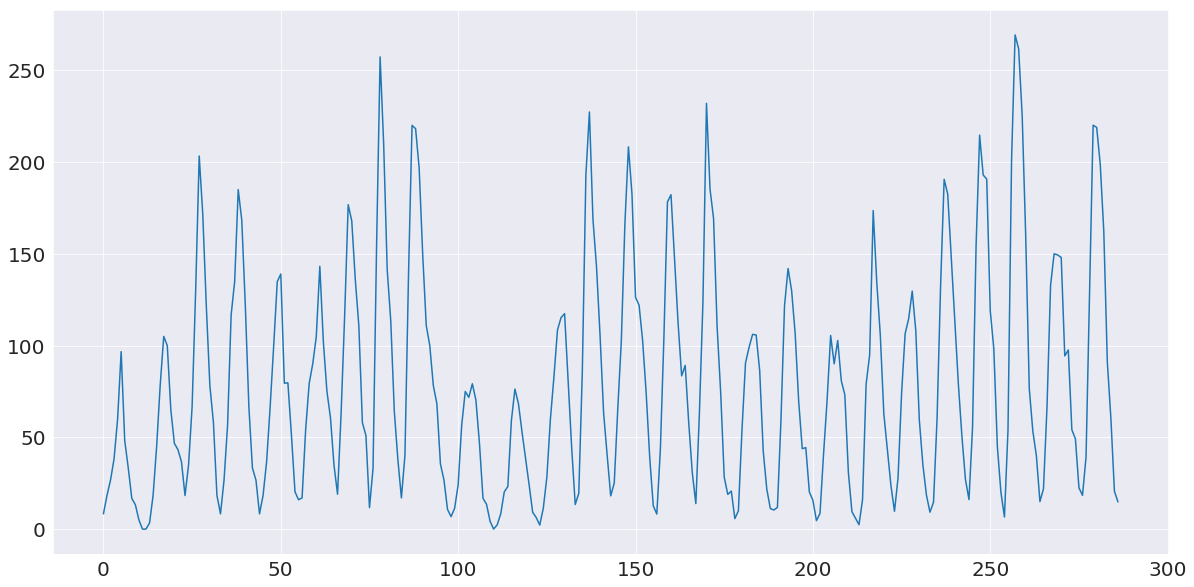

In [5]:
plt.figure(1, figsize=(20,10))
plt.plot(uni_var_train['sunspots'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

There seems to be some pattern in how the peaks of spaced out, and when they peak and decrease. 

Check to see if the time series is **covariance stationary**|: mean, variance, covariance with past and future values do not change over time

## 1. Check if the mean is changing

In [6]:
lower_half = uni_var_train.iloc[:uni_var_train.shape[0]//2]
upper_half = uni_var_train.iloc[uni_var_train.shape[0]//2:]

In [7]:
print("Mean of lower half: {}".format(lower_half.sunspots.mean()))
print("Mean of upper half: {}".format(upper_half.sunspots.mean()))

Mean of lower half: 71.13986013986013
Mean of upper half: 86.18680555555555


There seems to be quite the difference. When looking back at the plot, we see more higher peaks the second half of the time series. 

Split the data into bins, calculate the mean of each, and plot

In [8]:
chunks = np.array_split(uni_var_train, 40)

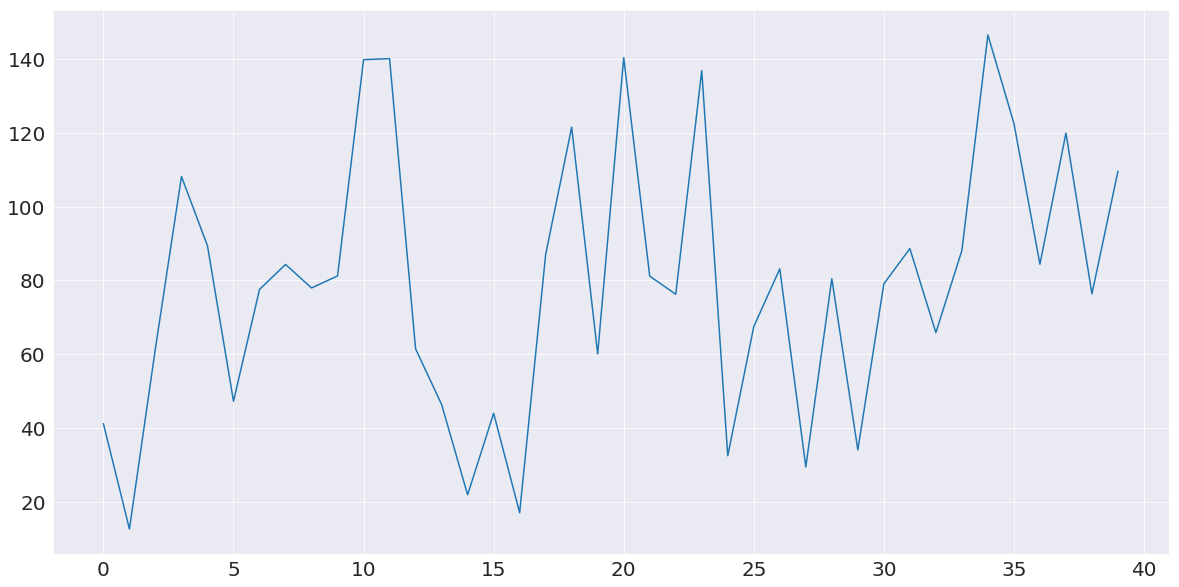

In [9]:
averages = []

for i in chunks:
    averages.append(i.sunspots.mean())

# print("Averaged sunspots (binsize=10): {}".format(averages))
plt.figure(2, figsize=(20,10))
plt.plot(averages)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

We can see a slight upward trend in the mean with binsize=40. (which is around a window size of 7 measurements averaged together) 

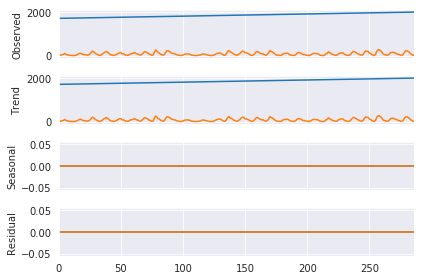

In [10]:
result = sm.tsa.seasonal_decompose(uni_var_train, 
                                   model='additive',
                                   freq=1)
result.plot()
plt.show()

## 2. Check for variance

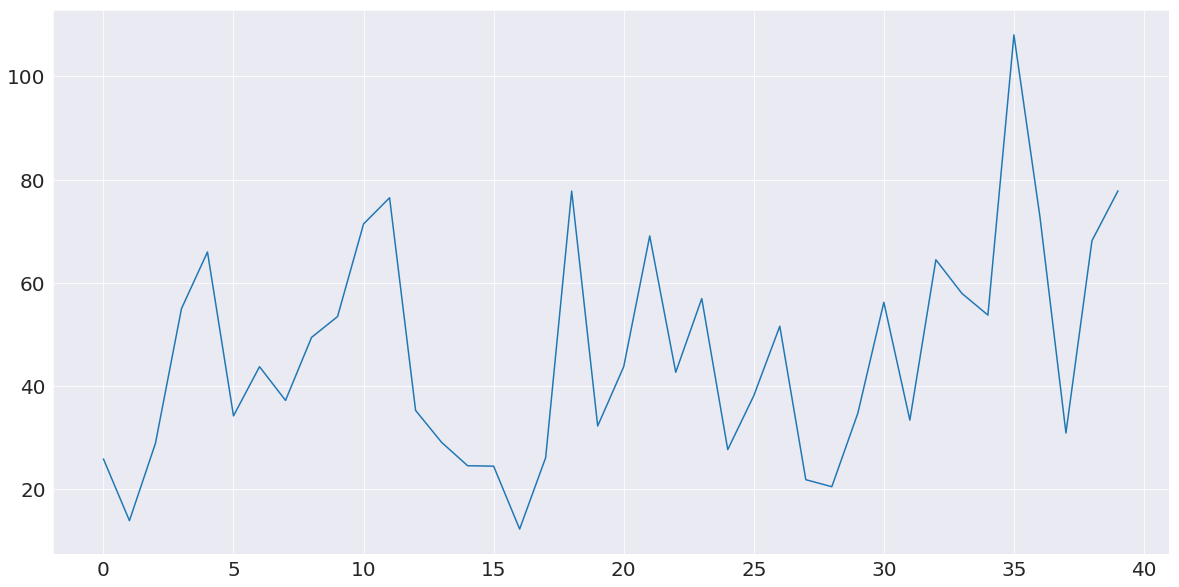

In [11]:
variance = []

for i in chunks:
    variance.append(sp.std(i.sunspots))

plt.figure(3, figsize=(20,10))
plt.plot(variance)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## 3. Plot correlation

Check randomness in time series. Compute autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any time-lag separations. If time series is non-random, there will be one or more autocorrelations that are not 0. 

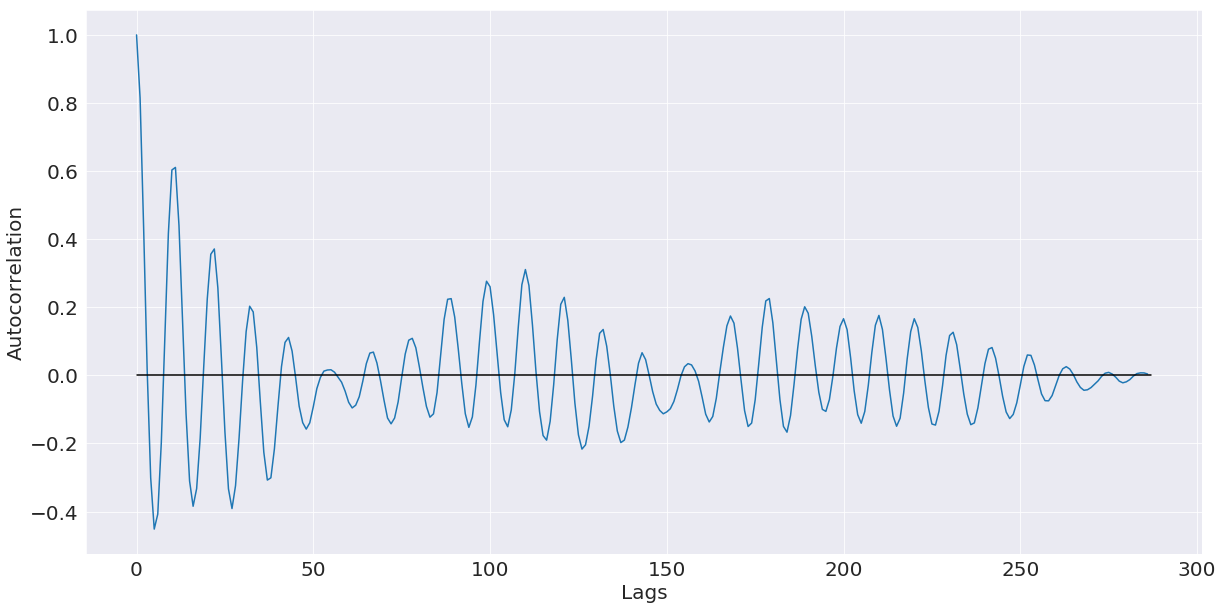

In [12]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(uni_var_train['sunspots'])

plt.figure(4, figsize=(20,10))
lags = uni_var_train.shape[0]
acf = sm.tsa.stattools.acf(uni_var_train['sunspots'], nlags=lags)
plt.plot(acf)
plt.plot(np.linspace(0,0,lags+1), color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Lags', fontsize=20)
plt.ylabel('Autocorrelation', fontsize=20)
plt.show()

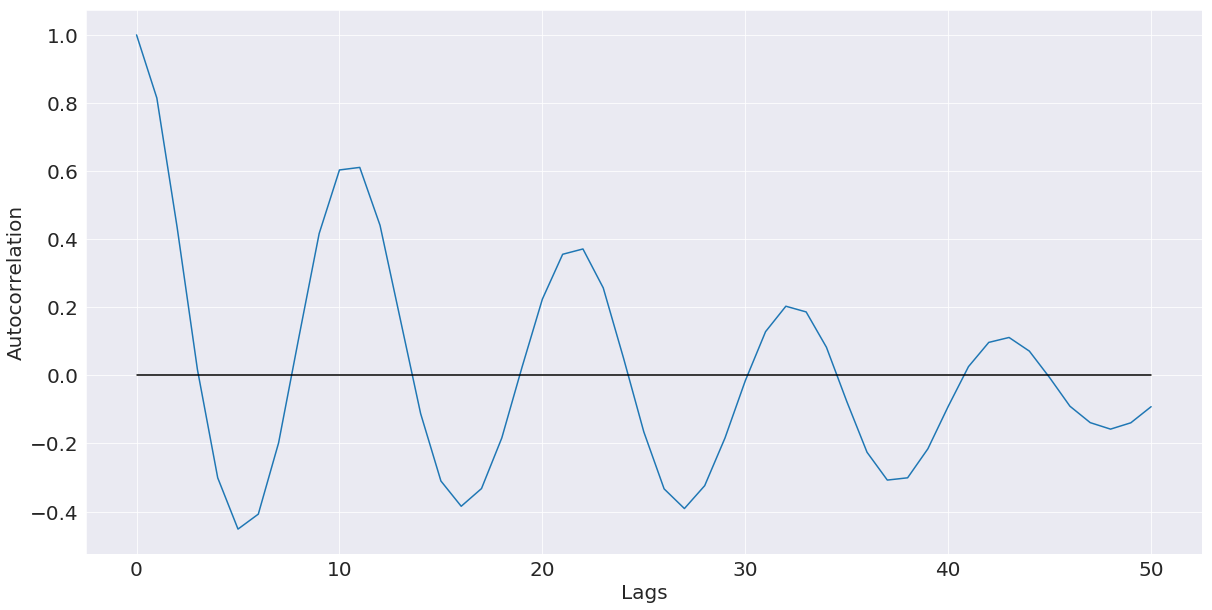

In [13]:
plt.figure(5, figsize=(20,10))
lags = 50
acf = sm.tsa.stattools.acf(uni_var_train['sunspots'], nlags=lags)
plt.plot(acf)
plt.plot(np.linspace(0,0,lags+1), color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Lags', fontsize=20)
plt.ylabel('Autocorrelation', fontsize=20)
plt.show()

## 4. Plot partial correlation

Partial autocorrelation is a summary of the relationship between an observation with observations at previous time steps with the relationship of intervening observations removed. 

The partial autocorrelation at some time k can be interpretted as the correlation that results after removing the effect of any correlations due to the terms at shorter lags

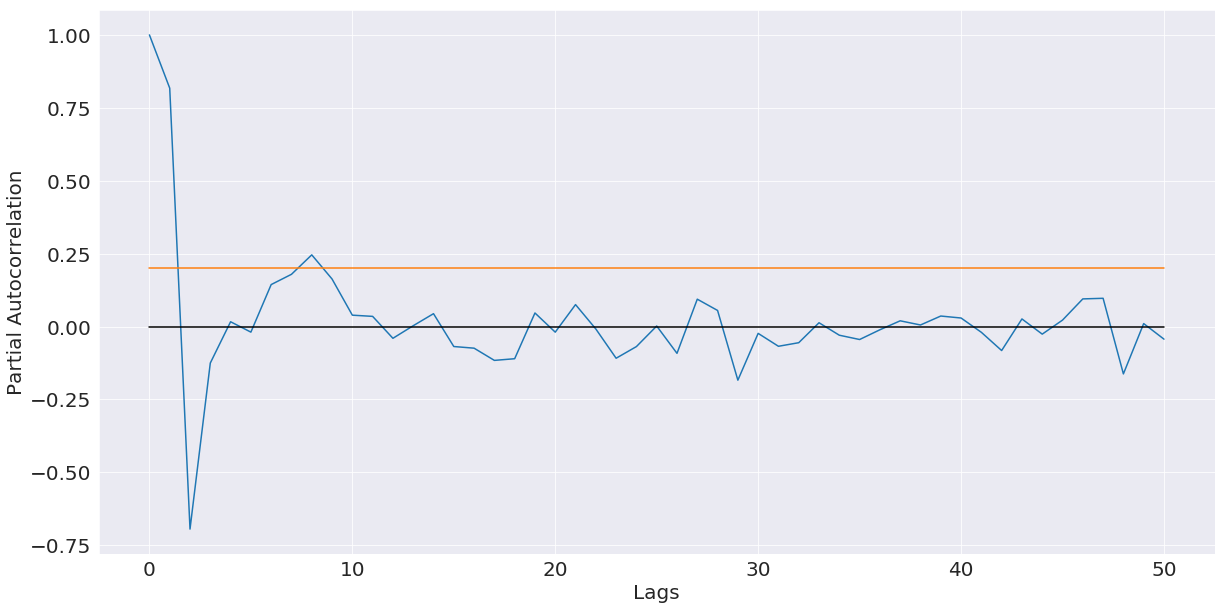

In [14]:
plt.figure(6, figsize=(20,10))
lags = 50
pacf = sm.tsa.stattools.pacf(uni_var_train['sunspots'], nlags=lags)
plt.plot(pacf)
plt.plot(np.linspace(0.2,0.2,lags+1))
plt.plot(np.linspace(0,0,lags+1), color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Lags', fontsize=20)
plt.ylabel('Partial Autocorrelation', fontsize=20)
plt.show()

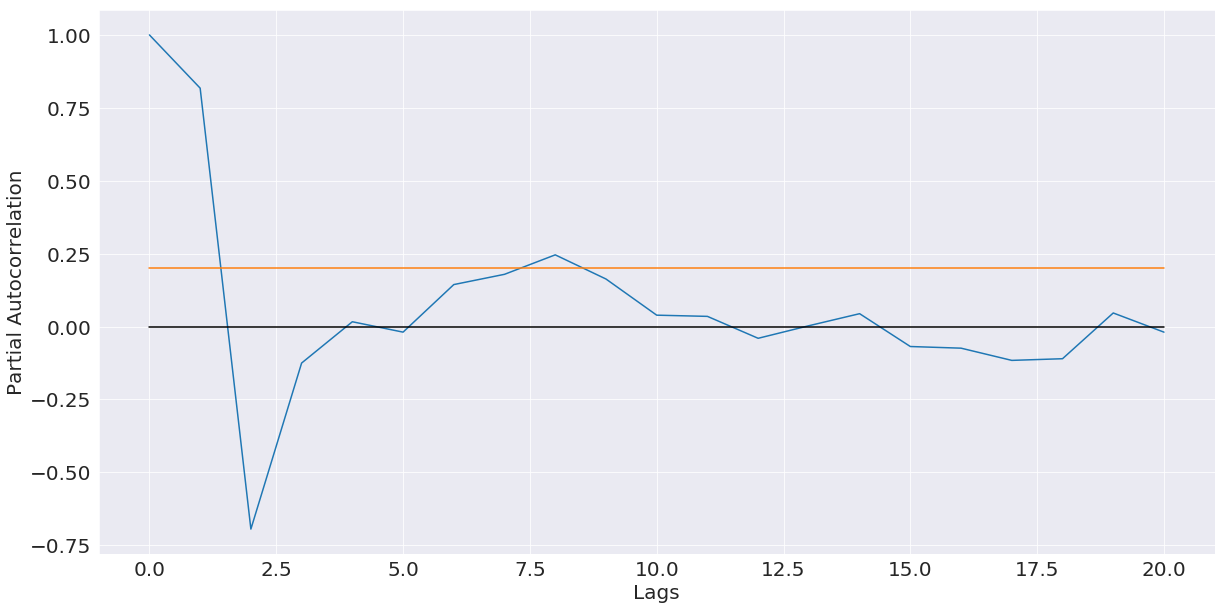

In [15]:
plt.figure(7, figsize=(20,10))
lags = 20
pacf = sm.tsa.stattools.pacf(uni_var_train['sunspots'], nlags=lags)
plt.plot(pacf)
plt.plot(np.linspace(0.2,0.2,lags+1))
plt.plot(np.linspace(0,0,lags+1), color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Lags', fontsize=20)
plt.ylabel('Partial Autocorrelation', fontsize=20)
plt.show()

lag size of 8 might be a good value to start. 

|Trial| Parameters    | RMSE   | MSE  | 
|:----|:--------------|:-------|:-----|
|1    |**(8, 1, 0)**  |25.3    |641.4 |
|2    |(9, 1, 0)      |58.1    |3377.9|
|3    |(10, 1, 0)     |56.4    |3174.9|
|4    |(11, 1, 0)     |56.7    |3217.5|
|5    |(10, 2, 0)     |216     |46751 |

## ARIMA Tuning

In [16]:
uni_var_train.head(3)

,year,sunspots
0,1700,8.3
1,1701,18.3
2,1702,26.7


In [17]:
# Split to compare outputs between rolling predictions and future
# predictions 
train, test = time_series_split(uni_var_train, 0.9)

Size of original data: 287
Size of training data: 258
Size of test data: 29


Running ARIMA_model...
Forecasting 29 time steps into the future


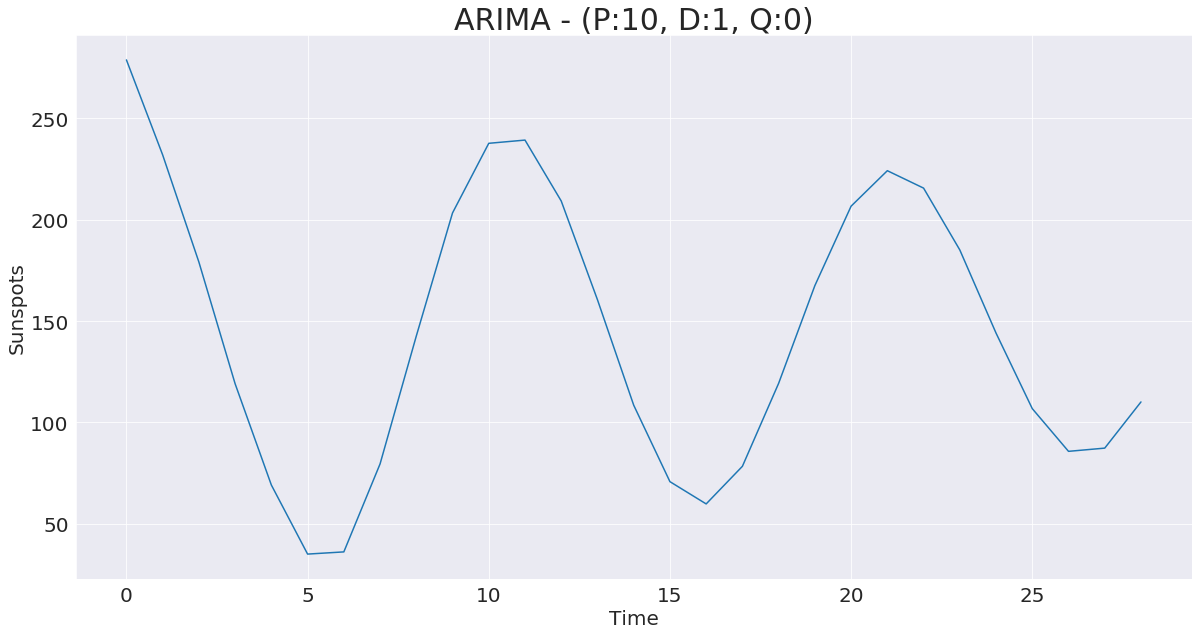

Finished in 53.1875s


In [18]:
results = ARIMA_model(data=train, y='sunspots', 
                      P=10, D=1, Q=0, future=True, 
                      N=29, output=True)

MSE: 3174.8669
RMSE: 56.3460


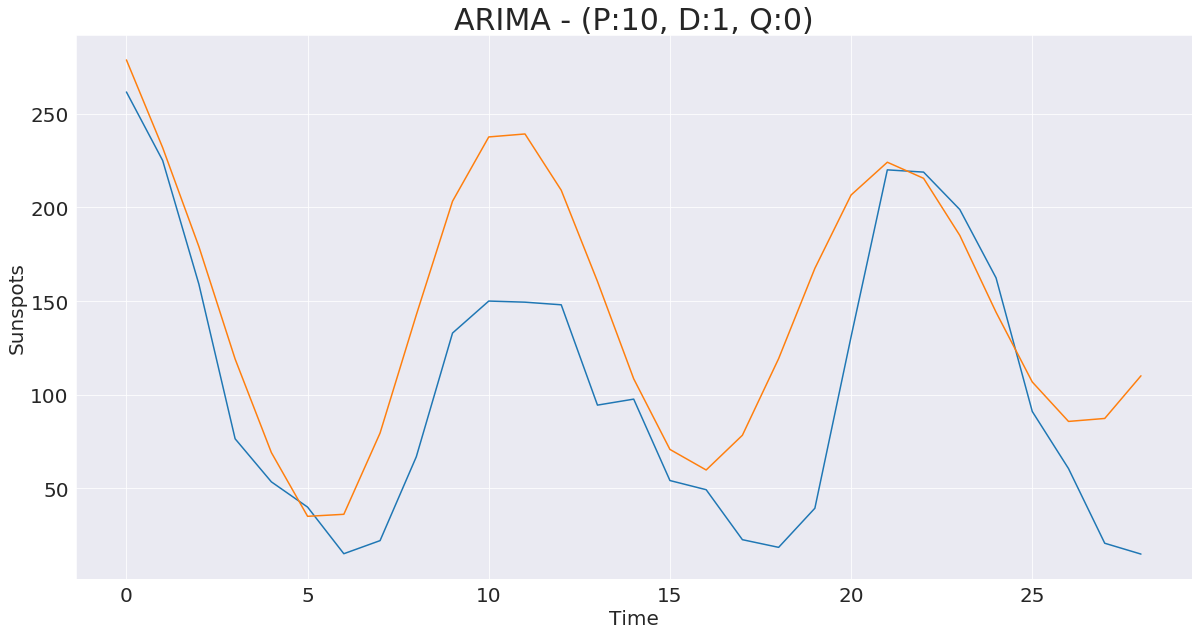

In [19]:
evaluation(test['sunspots'].tolist(), results, P=10, D=1, Q=0)

Compare output to rolling predictions, where every next "true" value is incorporated into the training data as it is observed. 

Running ARIMA_model...
Size of original data: 287
Size of training data: 258
Size of test data: 29
MSE: 641.3941
RMSE: 25.3258


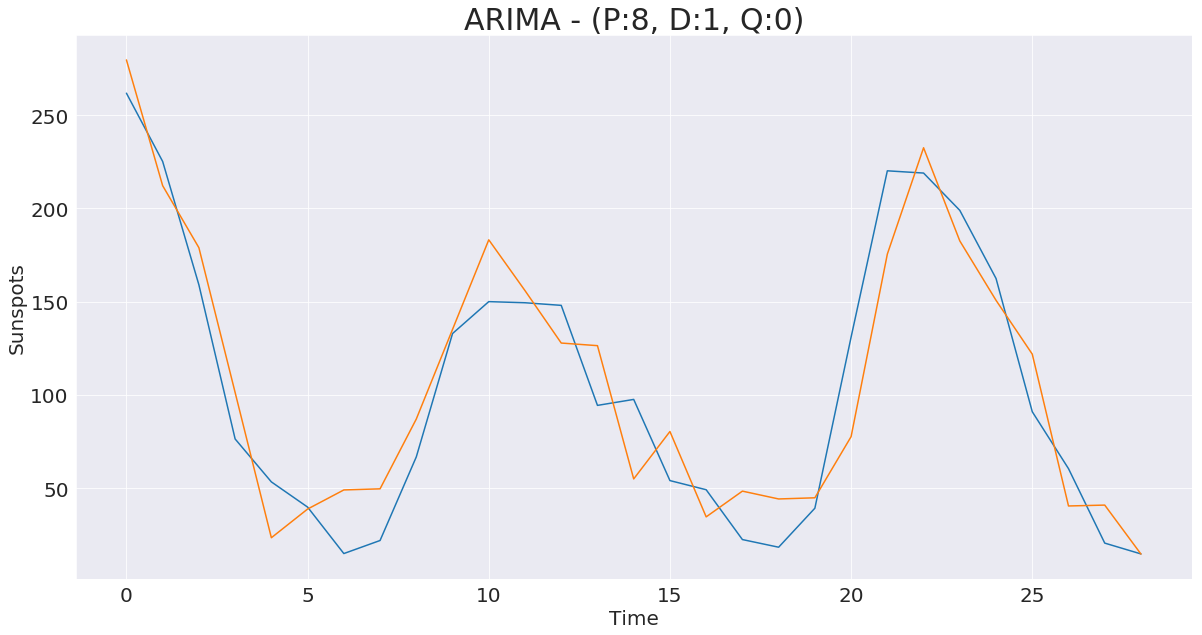

Finished in 22.2206s


In [20]:
results2 = ARIMA_model(data=uni_var_train, y='sunspots', 
                       P=8, D=1, Q=0, split=0.9, 
                       future=False, output=True)

As expected, performance is significantly better with rolling predictions. 

## Final ARIMA predictions

In [21]:
test = pd.read_csv(raw_data + "sunspots_yr_mean_test.csv")
print(test.shape[0])
test.head()

32


,year,sunspots
0,1987,NaN
1,1988,NaN
2,1989,NaN
3,1990,NaN
4,1991,NaN


Running ARIMA_model...
Forecasting 32 time steps into the future


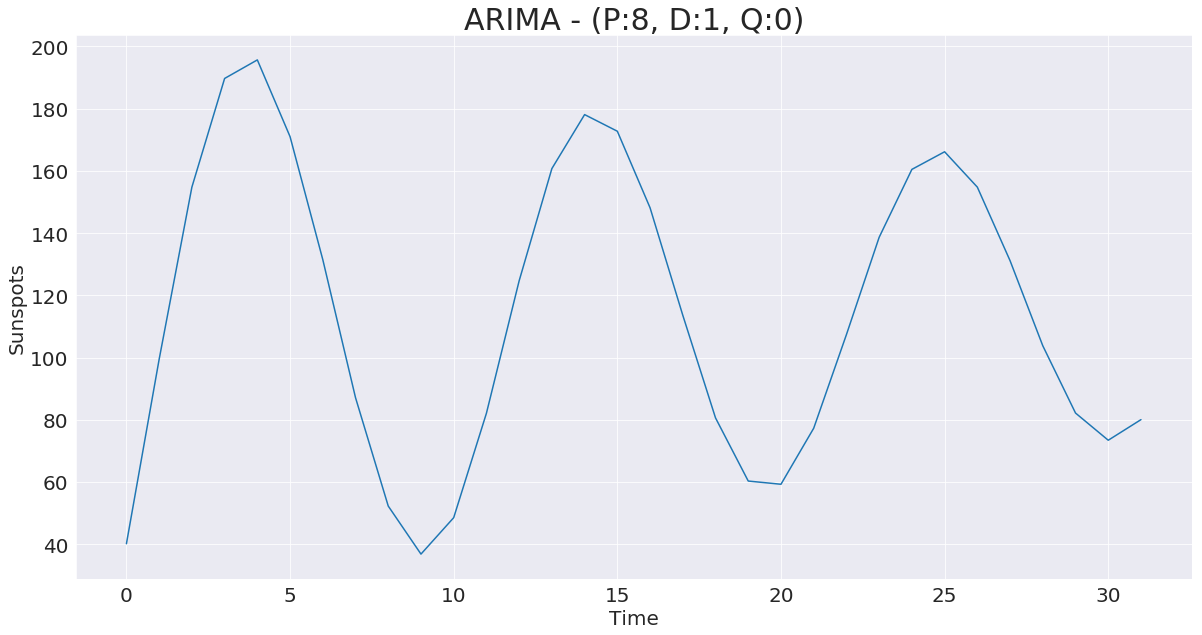

Finished in 21.8415s


In [22]:
test['sunspots'] = ARIMA_model(data=uni_var_train, y='sunspots', 
                               P=8, D=1, Q=0, future=True,
                               N=32, output=True)

In [23]:
test.to_csv("./submission/arima_predictions.csv", index=False)